In [2]:
!pip install lime

  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283845 sha256=2bc3f01dd7d20509e65c679d7f716926d2498c3123823b37ad99a1e18cb145ab
  Stored in directory: c:\users\tjame\appdata\local\pip\cache\wheels\e6\a6\20\cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [3]:
!pip install tsmoothie

In [4]:
!pip install altair

# Importing Libraries

In [28]:
%matplotlib inline

import bz2
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from collections import Counter
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import ConvolutionSmoother, ExponentialSmoother, LowessSmoother
from tsmoothie.bootstrap import BootstrappingWrapper
import datetime
from datetime import datetime
import altair as alt
from bs4 import BeautifulSoup
import requests
import re
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold

In [6]:
RANDOM_SEED = 655

# Importing Warriors Text Data Previously Extracted from Twitter

In [7]:
tweets_df_Warriors = pd.read_csv('tweets_df_Warriors.csv')
tweets_df_Warriors.head()

,Unnamed: 0,Unnamed: 0.1,user_name,user_location,user_description,user_verified,date,text,hashtags,source
0,0,0,NBA_Trades,"Toronto, Ontario",NaN,False,2022-10-09 16:00:21+00:00,Who wins the trade? #NBATrades #GoldenStateWar...,"['NBATrades', 'GoldenStateWarriors', 'DallasMa...",Twitter for iPhone
1,1,1,Love NBA,NaN,NAB Fanbase,False,2022-10-09 15:49:03+00:00,WHY is No one Talking About This INSANE Move f...,['DraymondGreen'],love.nba
2,2,2,Love NBA,NaN,NAB Fanbase,False,2022-10-09 15:17:03+00:00,Surprised Dray didn't pull a 👊\n \nhttps://t.c...,"['GoldenStateWarriors', 'PacificDivision', 'We...",love.nba
3,3,3,Alkass Digital,Doha,"An online news hub based in Doha, providing lo...",False,2022-10-09 15:07:29+00:00,Warriors rocked just days before the start of ...,NaN,Twitter Web App
4,4,4,Love NBA,NaN,NAB Fanbase,False,2022-10-09 14:50:03+00:00,Moses Moody talks Draymond Green after #Warrio...,"['Warriors', 'GoldenStateWarriors']",love.nba


In [8]:
Warriors_tweet_text = tweets_df_Warriors['text']
Warriors_text_source = tweets_df_Warriors['source']
d = {'Warriors_Tweet_Text':Warriors_tweet_text, 'Warriors_Text_Source':Warriors_text_source}
Warriors_tweet_df = pd.DataFrame(data=d)
Warriors_tweet_df.head()

,Warriors_Tweet_Text,Warriors_Text_Source
0,Who wins the trade? #NBATrades #GoldenStateWar...,Twitter for iPhone
1,WHY is No one Talking About This INSANE Move f...,love.nba
2,Surprised Dray didn't pull a 👊\n \nhttps://t.c...,love.nba
3,Warriors rocked just days before the start of ...,Twitter Web App
4,Moses Moody talks Draymond Green after #Warrio...,love.nba


# Cleaning the Data

In [9]:
Warriors_tweet_df['Warriors_Tweet_Text'] = Warriors_tweet_df['Warriors_Tweet_Text'].apply(lambda x: x.lower())

In [10]:
Warriors_tweet_df['Warriors_Tweet_Text'] = Warriors_tweet_df['Warriors_Tweet_Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
Warriors_tweet_df['Warriors_Tweet_Text'] = Warriors_tweet_df['Warriors_Tweet_Text'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x).split()))

In [11]:
Warriors_tweet_df.head()

,Warriors_Tweet_Text,Warriors_Text_Source
0,who wins the trade nbatrades goldenstatewarrio...,Twitter for iPhone
1,why is no one talking about this insane move f...,love.nba
2,surprised dray didn t pull a goldenstatewarrio...,love.nba
3,warriors rocked just days before the start of ...,Twitter Web App
4,moses moody talks draymond green after warrior...,love.nba


# Split the Data with Train-Test-Split

In [12]:
train_df, dev_df, test_df = np.split(Warriors_tweet_df.sample(frac=1, random_state=655),
                                    [int(.8*len(Warriors_tweet_df)), int(.9*len(Warriors_tweet_df))])

train_df, dev_df, test_df

(                                    Warriors_Tweet_Text Warriors_Text_Source
 1370  check out some warzone fun road to 100 subs wa...   Twitter for iPhone
 399   dreymond green knocked tf out jordan poole jor...   Twitter for iPhone
 3965  draymondgreen caught on video punching jordanp...       SocialPilot.co
 3169  hey regardless off what happens draymond is a ...  Twitter for Android
 990   draymond sounded like a smooth politician said...   Twitter for iPhone
 ...                                                 ...                  ...
 4882  celebrate the star of the nba season by expand...      Twitter Web App
 3647  we are providing world best iptv subscription ...  Twitter for Android
 984   fortunes keep and rebirth island 1 200 dubs li...   Streamlabs Twitter
 2573  warriors practice ty letsgowarriors andre anth...             love.nba
 463   steph curry slams jordan poole bad attitude ru...           TalkBasket
 
 [3941 rows x 2 columns],
                                    

# Convert the training/test corpus to TFIDF feature vectors

In [13]:
bigram_vectorizer = TfidfVectorizer(min_df=100, stop_words='english', ngram_range=(1,2))
X_train = bigram_vectorizer.fit_transform(train_df.Warriors_Tweet_Text)
X_dev = bigram_vectorizer.transform(dev_df.Warriors_Tweet_Text)
X_test = bigram_vectorizer.transform(test_df.Warriors_Tweet_Text)
y_train = list(train_df.Warriors_Text_Source)
y_dev = list(dev_df.Warriors_Text_Source)
y_test = list(test_df.Warriors_Text_Source)
X_train.shape
X_train, X_dev, X_test, y_train, y_dev, y_test

(<3941x90 sparse matrix of type '<class 'numpy.float64'>'
 	with 28091 stored elements in Compressed Sparse Row format>,
 <493x90 sparse matrix of type '<class 'numpy.float64'>'
 	with 3487 stored elements in Compressed Sparse Row format>,
 <493x90 sparse matrix of type '<class 'numpy.float64'>'
 	with 3447 stored elements in Compressed Sparse Row format>,
 ['Twitter for iPhone',
  'Twitter for iPhone',
  'SocialPilot.co',
  'Twitter for Android',
  'Twitter for iPhone',
  'dlvr.it',
  'Twitter for iPhone',
  'Twitter Web App',
  'Twitter for iPhone',
  'Twitter for Android',
  'SocialBee.io v2',
  'Twitter for Android',
  'SocialBee.io v2',
  'Twitter for iPhone',
  'Twitter for iPhone',
  'Twitter Web App',
  'love.nba',
  'love.nba',
  'SocialBee.io v2',
  'Twitter Web App',
  'Periscope',
  'Twitter Web App',
  'Twitter for iPhone',
  'Twitter for iPhone',
  'SocialBee.io v2',
  'Blog2Social APP',
  'SocialBee.io v2',
  'Twitter for Android',
  'Twitter Web App',
  'Twitter for iPh

# Check the Shape of the training/test data

In [14]:
X_train.shape

(3941, 90)

In [15]:
X_dev.shape

(493, 90)

In [16]:
X_test.shape

(493, 90)

# Check the label count for the training data

In [17]:
label_count = Counter(y_train)
label_count

Counter({'Twitter for iPhone': 1108,
         'SocialPilot.co': 1,
         'Twitter for Android': 486,
         'dlvr.it': 32,
         'Twitter Web App': 672,
         'SocialBee.io v2': 703,
         'love.nba': 348,
         'Periscope': 1,
         'Blog2Social APP': 83,
         'BestTLDApp': 56,
         'explore-botAPI': 2,
         'Sprout Social': 3,
         'THEDOTBEST': 77,
         'Streamlabs Twitter': 23,
         'Instagram': 30,
         'RetroSeasons San Francisco': 38,
         'raw-chili': 45,
         'Newsoneplace To Twitter': 6,
         'msperfect': 10,
         'Twitter for iPad': 25,
         'BestTLD': 27,
         'Hootsuite Inc.': 10,
         'javaku': 2,
         'StreamElements': 10,
         'TweetDeck': 32,
         'Loomly': 2,
         'SocialFlow': 4,
         'TweetDeck Web App': 1,
         'news247planet': 2,
         'directoalcorreo': 2,
         'Echofon': 6,
         'Xbox One Social': 2,
         'LaterMedia': 3,
         'WordPress.com': 1

# Hyperparameter tuning using GridSearchCv

In [18]:
# A list of parameters of the first classifier is listed to allow observation of what parameters could be specified and
# diagnosed during gridsearch

# Look at parameters used by our current LR
RFC = RandomForestClassifier()
print('Parameters currently in use:\n')
print(RFC.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [24]:
#create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#X_train_fs, X_test_fs, fs = select_features(X_train_scaled, y_train, X_test)

## identify parameters
param_grid = {'bootstrap' : [True], 
              'max_depth' : [1,2,3,4], 
              'max_features' : [1,2,3,4],
              'min_samples_split' : [1,2,3,4],
              'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200]}  

# perform grid search
# specify model
RFC = RandomForestClassifier()
grid_searcher = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=folds, n_jobs=-1, verbose=2)
grid_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:  7.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [1, 2, 3, 4],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200]},
             verbose=2)

In [25]:
# After running GridSearchCV, the best_params_ parameter was called to identify the recommended parameter setup

best_grid = grid_searcher.best_params_
best_grid

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 4,
 'min_samples_split': 4,
 'n_estimators': 100}

In [29]:
# Logistic Regression parameters were identified

# Look at parameters used by our current forest
LR = LogisticRegression()
print('Parameters currently in use:\n')
print(LR.get_params())

Parameters currently in use:

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [31]:
#create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# identify parameters
param_grid = {'penalty': ['l2', 'none', 'elasticnet'], 
            'l1_ratio' : [0,1], 
            'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
             'random_state':[0,42],
             'max_iter':[50,75,100,125,150,175,200,225,250,275,300]} 

# perform grid search
# specify model
LR = LogisticRegression()
grid_searcher1 = GridSearchCV(estimator=LR, param_grid=param_grid, cv=folds)
grid_searcher1.fit(X_train, y_train)

C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'l1_ratio': [0, 1],
                         'max_iter': [50, 75, 100, 125, 150, 175, 200, 225, 250,
                                      275, 300],
                         'penalty': ['l2', 'none', 'elasticnet'],
                         'random_state': [0, 42],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']})

In [32]:
#Identifying the best parameters to utilize
best_grid1 = grid_searcher1.best_params_
best_grid1

{'l1_ratio': 0,
 'max_iter': 75,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'saga'}

# Train the Model with Optimal Hyperparameters

In [34]:
lr_clf = LogisticRegression(random_state=RANDOM_SEED, multi_class='auto', l1_ratio=0, max_iter=75, 
                            penalty='none', solver='saga')
rf_clf = RandomForestClassifier(bootstrap=True, n_estimators=100, max_depth=4, max_features=4, min_samples_split=4,
                                random_state=RANDOM_SEED)

In [35]:
print('started fitting')
lr_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
print('finished fitting')

started fitting


C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1315: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\tjame\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


finished fitting


# Create a Dummy Baseline for Performance Comparison

In [36]:
random_clf = DummyClassifier(strategy='uniform', random_state=RANDOM_SEED).fit(X_train, y_train)

# Evaluate the Model

In [37]:
y_pred_dev = lr_clf.predict(X_dev)
y_pred_test = lr_clf.predict(X_test)
rf_y_pred_dev = rf_clf.predict(X_dev)
rf_y_pred_test = rf_clf.predict(X_test)
random_y_pred_dev = random_clf.predict(X_dev)
random_y_pred_test = random_clf.predict(X_test)
y_pred_dev, y_pred_test, rf_y_pred_dev, rf_y_pred_test, random_y_pred_dev, random_y_pred_test

(array(['Twitter Web App', 'SocialBee.io v2', 'SocialBee.io v2',
        'SocialBee.io v2', 'Twitter for iPhone', 'Twitter for Android',
        'Twitter for iPhone', 'BestTLDApp', 'Twitter for iPhone',
        'dlvr.it', 'Twitter for iPhone', 'THEDOTBEST',
        'Twitter for iPhone', 'Twitter for iPhone', 'THEDOTBEST',
        'Twitter for iPhone', 'Twitter Web App', 'Twitter for iPhone',
        'Twitter for iPhone', 'SocialBee.io v2',
        'RetroSeasons San Francisco', 'BestTLDApp', 'SocialRabbit Plugin',
        'love.nba', 'Twitter for iPhone', 'Twitter for iPhone',
        'Twitter for iPhone', 'Twitter for iPhone', 'Twitter for iPhone',
        'Twitter for iPhone', 'SocialBee.io v2', 'Twitter for iPhone',
        'love.nba', 'love.nba', 'Twitter Web App', 'Twitter Web App',
        'Twitter for iPhone', 'Twitter Web App', 'Twitter for iPhone',
        'Twitter Web App', 'Twitter for Android', 'Twitter Web App',
        'SocialBee.io v2', 'Twitter for iPhone', 'SocialBee.io

# Score the Predictions

In [38]:
lr_test_f1 = f1_score(y_test, y_pred_test, average='macro')
rf_test_f1 = f1_score(y_test, rf_y_pred_test, average='macro')
rand_test_f1 = f1_score(y_test, random_y_pred_test, average='macro')
lr_dev_f1 = f1_score(y_dev, y_pred_dev, average='macro')
rf_dev_f1 = f1_score(y_dev, rf_y_pred_dev, average='macro')
rand_dev_f1 = f1_score(y_dev, random_y_pred_dev, average='macro')
lr_test_f1, rf_test_f1, rand_test_f1, lr_dev_f1, rf_dev_f1, rand_dev_f1

(0.33407315266974696,
 0.08056247260501699,
 0.002225105320468861,
 0.4216352404353765,
 0.10355810267899915,
 0.0024845407450857244)

# Explaining Predictions Using Lime

# Creating Explainer and Classifier Pipelines

In [39]:
LTE = LTE = LimeTextExplainer(kernel_width=10, kernel=None, verbose=False, class_names=['sarcastic','non-sarcastic'], 
                        feature_selection='auto', split_expression='\W+', bow=True, mask_string=None, 
                        random_state=RANDOM_SEED, char_level=False)
rf_pipe = make_pipeline(bigram_vectorizer, rf_clf)
lr_pipe = make_pipeline(bigram_vectorizer, lr_clf)

In [40]:
test_row_df = test_df.sample(1, random_state=RANDOM_SEED)
_, inst_text, label = next(test_row_df.itertuples())

print('Comment has text "%s"' %(inst_text))
print('True label: %s' % label)
print('LogisticRegression Probability(Sarcastic) =', lr_pipe.predict_proba([inst_text])[0, 1])
print('RandomForest Probability(Sarcastic) =', rf_pipe.predict_proba([inst_text])[0, 1])

Comment has text "the pool party is over draymondgreen poole warriors nba"
True label: Twitter for iPhone
LogisticRegression Probability(Sarcastic) = 1.987189386256394e-09
RandomForest Probability(Sarcastic) = 0.008222984315260848


# Use the explainer object to generate predictions for each of the classifier pipelines

In [41]:
rf_explanation = LTE.explain_instance(inst_text, rf_pipe.predict_proba, num_features=10)

lr_explanation = LTE.explain_instance(inst_text, lr_pipe.predict_proba, num_features=10)
rf_explanation, lr_explanation

(<lime.explanation.Explanation at 0x1542ad4c340>,
 <lime.explanation.Explanation at 0x1542ad4c850>)

# Examine the Explanations

# We will examine the amount of negative vs positive scoring-weight Lime gives to some of the keywords from the tweet text

In [42]:
for feat, val in lr_explanation.as_list():
    print('LogisticRegression has an estimated weight of %f on feature "%s"' % (val, feat))


LogisticRegression has an estimated weight of -0.000001 on feature "warriors"
LogisticRegression has an estimated weight of -0.000001 on feature "nba"
LogisticRegression has an estimated weight of -0.000001 on feature "poole"
LogisticRegression has an estimated weight of -0.000001 on feature "draymondgreen"
LogisticRegression has an estimated weight of -0.000000 on feature "over"
LogisticRegression has an estimated weight of -0.000000 on feature "pool"
LogisticRegression has an estimated weight of -0.000000 on feature "the"
LogisticRegression has an estimated weight of -0.000000 on feature "is"
LogisticRegression has an estimated weight of -0.000000 on feature "party"


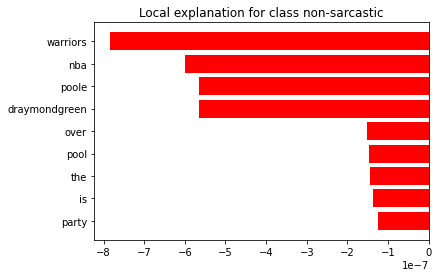

In [43]:
fig = lr_explanation.as_pyplot_figure()

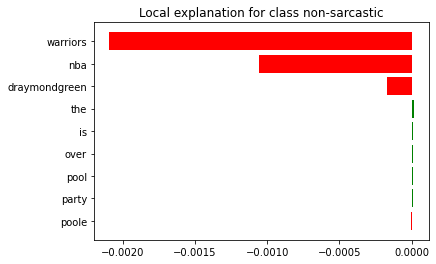

In [44]:
fig = rf_explanation.as_pyplot_figure()